In [18]:
import torch
import torch.nn as nn
from torch import topk
from torchvision import transforms
from PIL import Image

import os
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'y')

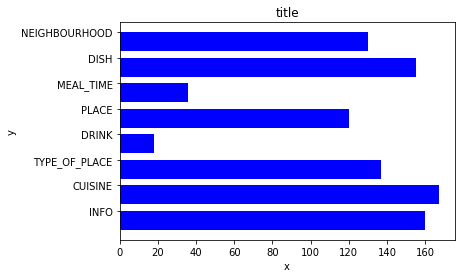

In [17]:
x = [u'INFO', u'CUISINE', u'TYPE_OF_PLACE', u'DRINK', u'PLACE', u'MEAL_TIME', u'DISH', u'NEIGHBOURHOOD']
y = [160, 167, 137, 18, 120, 36, 155, 130]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('title')
plt.xlabel('x')
plt.ylabel('y')      
#plt.show()

In [16]:
class2num = {'broad leaves': 0, 'coniferous tree': 1, 'grass land': 2, 'hard ground': 3, 'leafless': 4, 'stalk': 5, 'stone': 6, 'trunk': 7, 'water': 8, 'wire': 9}
num2class = {0: 'broad leaves', 1: 'coniferous tree', 2: 'grass land', 3: 'hard ground', 4: 'leafless', 5: 'stalk', 6: 'stone', 7: 'trunk', 8: 'water', 9: 'wire'}

resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = torch.device('cpu')

data_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

alexnet = torch.load('alexnet-111_10_5_5.pkl', map_location=torch.device('cpu'))
vgg19 = torch.load('vgg19-111_8_5_5.pkl', map_location=torch.device('cpu'))
res50 = torch.load('resnet50-111_3_5_5.pkl', map_location=torch.device('cpu'))
res152 = torch.load('resnet152-111_5_5_5.pkl', map_location=torch.device('cpu'))

models = {
    'AlexNet'    :alexnet,
    'VGG19'     :vgg19,
    'ResNet50'  :res50,
    'ResNet152' :res152
}

In [58]:
def pred_single_image(modelname, data_transforms, img_path):
    im = Image.open(img_path).convert("RGB")
    tsr = data_transforms(im).unsqueeze(0).to(device)
    outputs = models[modelname](tsr)
    probs = nn.functional.softmax(outputs, dim=1).squeeze()
    probs = probs.detach().numpy()
    pre_label_id = probs.argmax()
    true_label_id = imgName2num(img_path)
    print(pre_label_id, true_label_id)
    is_correct = (pre_label_id==true_label_id)
    print('Is correct? ', is_correct, 'True Label', num2class[true_label_id])
    return is_correct, probs

def plot_probs(image_path, modelname, probs, is_correct):
    font1 = {
#     'family':'Times New Roman',
    'family':'Arial',
    'weight':'bold',
    'size'  : 12,
    }
    display_size = 400
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=500)
    f.set_size_inches(8, 4)

    plt.tight_layout(pad=0)
    if is_correct == True:
        pred_color= 'tomato'
        save_folder = 'corrects'
    else:
        pred_color = 'cyan'
        save_folder = 'wrongs'
    x = list(num2class.keys())
    y = probs
    width = 1.0
    ind = np.arange(len(num2class.keys()))  # the x locations for the groups
    ax2.barh(ind, y, width, color=pred_color)
    
    im = Image.open(image_path)
    im = im.resize((display_size,display_size),Image.ANTIALIAS)
    ax1.imshow(im, aspect='auto')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    for i in range(10):
        ax2.text(.005, i-0.08, num2class[i], color='k', fontdict=font1)
        ax2.text(0.6, i-0.08, '{:<5.2f}%'.format(100*probs[i]), color='blue', fontdict=font1)
    
    ax2.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
    ax2.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
    ax2.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
    ax2.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

    ax2.set_xticks([])
    ax2.set_yticks([])
    
    for p in ax1.spines.keys():
        ax1.spines[p].set_visible(False);###设置底部坐标轴是否可见
    
    
    savename = os.path.join('./pred_show_imags',model_name,save_folder,os.path.basename(image_path).split('.')[0]+'_{}.png'.format(modelname))
    print('Result saves as {}...'.format(savename))
    plt.savefig(savename, dpi=300)
    plt.clf()

    
def imgName2num(image_path):
    baseName = os.path.basename(image_path)
    folder_id = baseName[1]
    id2num = {
        '0' : class2num['broad leaves'],
        '1' : class2num['coniferous tree'],
        '2' : class2num['hard ground'],
        '3' : class2num['leafless'],
        '4' : class2num['stalk'],
        '5' : class2num['stone'],
        '6' : class2num['trunk'],
        '7' : class2num['grass land'],
        '8' : class2num['water'],
        '9' : class2num['wire'],
    }
#     print(baseName, folder_id)
    return id2num[str(folder_id)]
    

In [59]:
model_name = 'ResNet152'

image_path = './samples/000019.jpg'
is_correct, probs = pred_single_image(model_name, data_transforms, image_path)
plot_probs(image_path=image_path, modelname=model_name, probs=probs, is_correct=is_correct)

4 0
Is correct?  False True Label broad leaves
Result saves as ./pred_show_imags\ResNet152\wrongs\000019_ResNet152.png...


<Figure size 4000x2000 with 0 Axes>

In [34]:
# model_name = 'ResNet50'

# is_correct, probs = pred_single_image(model_name, data_transforms, image_path)
# plot_probs(image_path=image_path, modelname=model_name, probs=probs, is_correct=is_correct)

In [35]:
# model_name = 'ResNet50'
# image_path = './samples/000003.jpg'
# is_correct, probs = pred_single_image(model_name, data_transforms, image_path)
# plot_probs(image_path=image_path, modelname=model_name, probs=probs, is_correct=is_correct)

In [40]:
import matplotlib as mpl
mpl.use('Agg')
imgs = os.listdir('./samples/')
imgs = [os.path.join('./samples', img) for img in imgs]

In [41]:
# model_name = 'ResNet50'

# len(imgs)
# # for i, fn in enumerate(imgs[:100]):
# # for i, fn in enumerate(imgs[100:200]):
# # for i, fn in enumerate(imgs[200:300]):
# for i, fn in enumerate(imgs[300:]):
#     print(i, fn)
#     is_correct, probs = pred_single_image(model_name, data_transforms, fn)
#     plot_probs(image_path=fn, modelname=model_name, probs=probs, is_correct=is_correct)

In [54]:
model_name = 'VGG19'

# len(imgs)
# for i, fn in enumerate(imgs[:100]):
# for i, fn in enumerate(imgs[100:200]):
# for i, fn in enumerate(imgs[200:300]):
# for i, fn in enumerate(imgs[300:]):
#     print(i, fn)
#     is_correct, probs = pred_single_image(model_name, data_transforms, fn)
#     plot_probs(image_path=fn, modelname=model_name, probs=probs, is_correct=is_correct)

In [57]:
model_name = 'AlexNet'

# len(imgs)
# for i, fn in enumerate(imgs[:100]):
# for i, fn in enumerate(imgs[100:200]):
# for i, fn in enumerate(imgs[200:300]):
for i, fn in enumerate(imgs[300:]):
    print(i, fn)
    is_correct, probs = pred_single_image(model_name, data_transforms, fn)
    plot_probs(image_path=fn, modelname=model_name, probs=probs, is_correct=is_correct)

0 ./samples\060202.jpg
7 7
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\060202_AlexNet.png...
1 ./samples\060203.jpg
7 7
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\060203_AlexNet.png...
2 ./samples\060209.jpg
7 7
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\060209_AlexNet.png...
3 ./samples\060211.jpg
7 7
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\060211_AlexNet.png...
4 ./samples\070003.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070003_AlexNet.png...
5 ./samples\070005.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070005_AlexNet.png...
6 ./samples\070012.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070012_AlexNet.png...
7 ./samples\070023.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070023_AlexNet.png...
8 ./samples\070024.jpg
2 2
Is correct?  True
Result save

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Result saves as ./pred_show_imags\AlexNet\corrects\070081_AlexNet.png...
21 ./samples\070092.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070092_AlexNet.png...
22 ./samples\070094.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070094_AlexNet.png...
23 ./samples\070096.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070096_AlexNet.png...
24 ./samples\070110.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070110_AlexNet.png...
25 ./samples\070111.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070111_AlexNet.png...
26 ./samples\070117.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070117_AlexNet.png...
27 ./samples\070120.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\corrects\070120_AlexNet.png...
28 ./samples\070128.jpg
2 2
Is correct?  True
Result saves as ./pred_show_imags\AlexNet\correc

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

<Figure size 4000x2000 with 0 Axes>

In [47]:
# model_name = 'ResNet152'

# len(imgs)
# for i, fn in enumerate(imgs[:100]):
# for i, fn in enumerate(imgs[100:200]):
# for i, fn in enumerate(imgs[200:300]):
# for i, fn in enumerate(imgs[300:]):
#     print(i, fn)
#     is_correct, probs = pred_single_image(model_name, data_transforms, fn)
#     plot_probs(image_path=fn, modelname=model_name, probs=probs, is_correct=is_correct)